# Template `Jupyter` notebook for computing stability scores from experimental data uploaded to TACC

This notebook is a template for computing stability scores starting from raw FACS and deep-sequencing data uploaded by BIOFAB to TACC.

There are five main sections:

1. Define all input variables
2. Compile all metadata into a single `experiments.csv` file for use as input for computing EC50 values
3. Compute EC50 values from the experimental data
4. Compute stabiltiy scores from EC50 values
5. Generate summary plots

As an example, this notebook analyzes data from a previous experiment with data located within the `sd2e-community/` directory on TACC:

    sd2e-community/shared-q1-workshop/strcklnd/protein_design_data/Plan_18338

The `sd2e-community/` directory is accessible to anyone. For instance, it is located at the followig path for me:
    
    /work/05402/haddox/jupyter/
    
Hugh Haddox, October-8-2018

## Import `Python` modules

In [1]:
import os
import sys
sys.path.append('scripts/')
import prot_stab_utils
import re
import glob

import xml.etree.ElementTree as ET
sys.path.append("/home/jupyter/tacc-work/jupyter_packages/lib/python2.7/site-packages")
from FlowCytometryTools import *

import numpy as np
import math
import scipy.stats
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")
from IPython.display import Image

## 1) Define all input variables

The below cell contains ***all*** input variables for the notebook. Just change these variables and then run the below cells in an automated fashion.

### Input variables for compiling experimental metadata

Typically, the BIOFAB uploads all data in a single folder, which in turn contains the following files/sub-directories:

* `manifest.csv`: a file that lists all samples tested in the experiment, along with metadata for each sample, such as unique IDs for locating files with associated FACS and deep-sequencing data.
* `ngs_data/`: a directory with all deep-sequencing data.
* `facs_data/`: a directory with all FACS data.

Below are input variables that are relevant to compiling these data:

* `summary_file`: a path to a CSV file with metadata for each sample
* `library_name`: the name of the library in the `strain` column of the `summary_file`. There are usually multiple values, including the library of interest, as well as controls (e.g., `AMA1-best`).

* `map_job_id_to_sort_round`: a dictionary that is used to match values in the `sort_job` column of `manifest.csv` (dictionary key) to the corresponding round of sorting (dictionary value). For instance, the original experiment from Rocklin et al., 2017, Science, involves three rounds of sorting: the first round with the naive library and the libraries treated with the two lowest concentrations of protease, the second round with library treated with the two intermediate concentrations of protease, and the third round with the library treated with the two highest concentrations of protease.

* `sort_rounds_with_identical_control`: a string of comma-delimited integers giving sorting rounds where the same sample was used as the protease-naive control for both proteases. These samples provide a baseline for how many cells are expected to pass the sorting threshold in the *absence* of protease. Typically, this is true for the first round of sorting, in which case `1` would be an appropriate entry.

* `fastq_dir`: a path to a folder with the deep-sequencing data

* `facs_dir`: a path to a folder with the FACS data

* `resultsdir`: the path to a directory where all results from this script will be stored. This directory will be created if it does not already exist.

* `experimental_metadata_output_file`: the path of the output file that will be created. This file is similar to the `experiments.csv` file from Rocklin et al, 2017, Science.

In [2]:
# Define input files and directories
data_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/protein_design_data/Plan_18338'
summary_file = os.path.join(data_dir, 'manifest.csv')
fastq_dir = os.path.join(data_dir, 'ngs_data/')
facs_dir = os.path.join(data_dir, 'facs_data/')

# Define variables that are relevant for parsing the
# input summary file
library_name = 'protein design downselect 3 with ladder 1'
map_job_id_to_sort_round = {
    'Job_72019' : 1, 'Job_72263' : 2, 'Job_72471' : 3
}
sort_rounds_with_identical_control = [1]

# Define the path to the output summary file
resultsdir = "results/template_notebook"
experimental_metadata_output_file = os.path.join(resultsdir, 'experimental_metadata_from_script.csv')

### Input variables for computing EC50 values and stability scores from experimental data

* `designed_sequences_file` : the path to a CSV file giving the name and protein sequence for each input design. See [here](data/Rocklin_2017_Science/designed_protein_sequences.csv) for an example. In this file, each row specifies a design and each column specifies information about that design. This file must have the following comma-delimited columns:
    * `name` : a unique name for the design
    * `protein_sequence` : the protein sequence of the design

* `pare_path` : a path to the program [`PEAR`](https://sco.h-its.org/exelixis/web/software/pear/)

* `five_prime_flanking_seq`: a DNA sequence that flanks the coding sequence of interest on the 5' end of the sequencing read (string). The coding sequence should begin immediately after the final nucleotide of this flanking sequence. This flanking sequence and the one given by `three_prime_flanking_seq` will be used to extract the DNA coding sequence from each sequencing read and then translate it into a protein dsequence. Note: the default sequence used in Rocklin et al., 2017, Science was `CATATG`.

* `three_prime_flanking_seq`: a DNA sequence that flanks the coding sequence of interest on the 3' end of the sequencing read (string). The coding sequence should begin immediately before the first nucleotide of this flanking sequence. Note: this DNA sequence should be in the same 5'-to-3' orientation as `five_prime_flanking_seq`. Note: the default sequence used in Rocklin et al., 2017, Science was `CTCGAG`

* `conc_factor`: the fold-change in protease concentration between selection steps, i.e., when `selection_strength` is incrimented by a value of one. A value of 3 would indicate that the protease concentration is increased by 3 fold between selection steps. Note: leave this value blank for samples that have not been treated with any protease.

* `proteases`: a list of the proteases used in the experiment that are lower-case versions of the names in the file specified by the `summary_file` input variable.

In [3]:
designed_sequences_file = 'data/template_notebook/designed_sequences.csv'
pear_path = '/home/05402/haddox/software/pear/bin/pear'
five_prime_flanking_seq = 'CATATG'
three_prime_flanking_seq = 'CTCGAG'
conc_factor = '3'
proteases = ['trypsin', 'chymotrypsin']

## 2) Compile all metadata into a single `experiments.csv` file for use as input for computing EC50 values

The goal of this section is to compile all metadata on TACC uploaded by the BIOFAB for a given experiment. The result of this section is an `experiments.csv` file, similar to the one from Rocklin et al., that is used as input for computing EC50 values. For more details on this file, see the documentation for the script `compute_ec50_values_from_deep_sequencing_data.py` in the `README.md` file at the root of this repository.

### First, read in metadata from the input `manifest.csv` file

In [4]:
# Read in data
summary_df = pandas.read_csv(summary_file)

# For each sample, specify a unique file prefix that will be used to find FASTQ files for that sample
summary_df['aq_item_id'] = summary_df['aq_item_id'].fillna(0).astype(int)
summary_df['fastq_id'] = summary_df['aq_item_id'].apply(
    lambda x: os.path.join(str(x), 'Files/')
)

# For each sample, specify a unique file prefix that will be used to find FACS files for that sample
summary_df.rename(columns={'sort_job':'job_id'}, inplace=True)
summary_df['facs_file_prefix'] = summary_df.apply(
    lambda row: os.path.join(facs_dir, str(row['job_id']), str(row['facs_filename_stub'])), axis=1
)

# Make other changes to the dataframe
summary_df['protease'] = summary_df['protease'].apply(lambda x: x.lower())
summary_df.set_index(['protease', 'concentration'], inplace=True)
summary_df.sort_index(inplace=True)

# Remove entries that do not correspond to the library of interest
summary_df = summary_df[
    summary_df['strain'] == library_name
]

### Analyze the FACS data, recording relevant information for each sample such as the fraction of cells passing the FITC cutoff for both the sample and untreated controls, as well as the total number of cells collected for each sample

In [5]:
def find_facs_file(facs_file_prefix):
    """Find all files with a given prefix"""
    
    # Find all files with given prefix, make sure there
    # is only one matching file, and return its path
    facs_files = glob.glob(facs_file_prefix + '*.fcs')
    if len(facs_files) == 1:
        return facs_files[0]
    elif len(facs_files) == 0:
        return None
    
def s_log(sample, channel_names):
    """Transform FACS data to log10 space"""
    
    # Copy dataframe and get relevant FACS data
    new_sample = sample.copy()
    new_data = new_sample.data

    # Transform the FACS data to log10 space
    for channel_name in channel_names:
        new_data[channel_name] = np.log10(new_data[channel_name])
    
    # Replace values of negative infinity with negative one, remove
    # entries with `nan` values, and return a dataframe with the
    # final values
    new_data.replace(to_replace = -np.inf, value = -1, inplace = True)
    new_data = new_data.dropna()
    new_sample.data = new_data
    
    return new_sample

def compute_fraction_collected(fcs_file, sorting_threshold=3.0):
    """Compute the fraction of cells that passed the FITC gate during sorting"""
    
    # Return `None` if the file doesn't exist
    if not isinstance(fcs_file, str):
        return None
    elif not os.path.isfile(fcs_file):
        return None
    
    # Get FACS data from a given file and for a given chanel
    else:
        sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
        sample = s_log(sample, [facs_channel_name])
        df = sample.data

        # Count the number of total events and events passing the gate
        total_number_of_recorded_events = float(len(df.index.values))
        number_of_events_passing_fitc_gate = sum(df[facs_channel_name] > sorting_threshold)
        fraction_collected = number_of_events_passing_fitc_gate / total_number_of_recorded_events
        #return (pandas.Series([total_number_of_recorded_events, number_of_events_passing_fitc_gate, fraction_collected]))
        return fraction_collected

First, compute the fraction of cells that were collected for each sample

In [6]:
# Search for the FACS file associated with each sample
summary_df['facs_file_name'] = summary_df['facs_file_prefix'].apply(
    lambda x: find_facs_file(x)
)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Compute the faction of cells that passed the FITC gate for each sample
summary_df['fraction_collected'] = summary_df.apply(
    lambda row: compute_fraction_collected(row['facs_file_name']), axis=1
)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


Plot the distribution of FITC values for each sample with this type of data, as well as the sorting threshold used to select cells

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


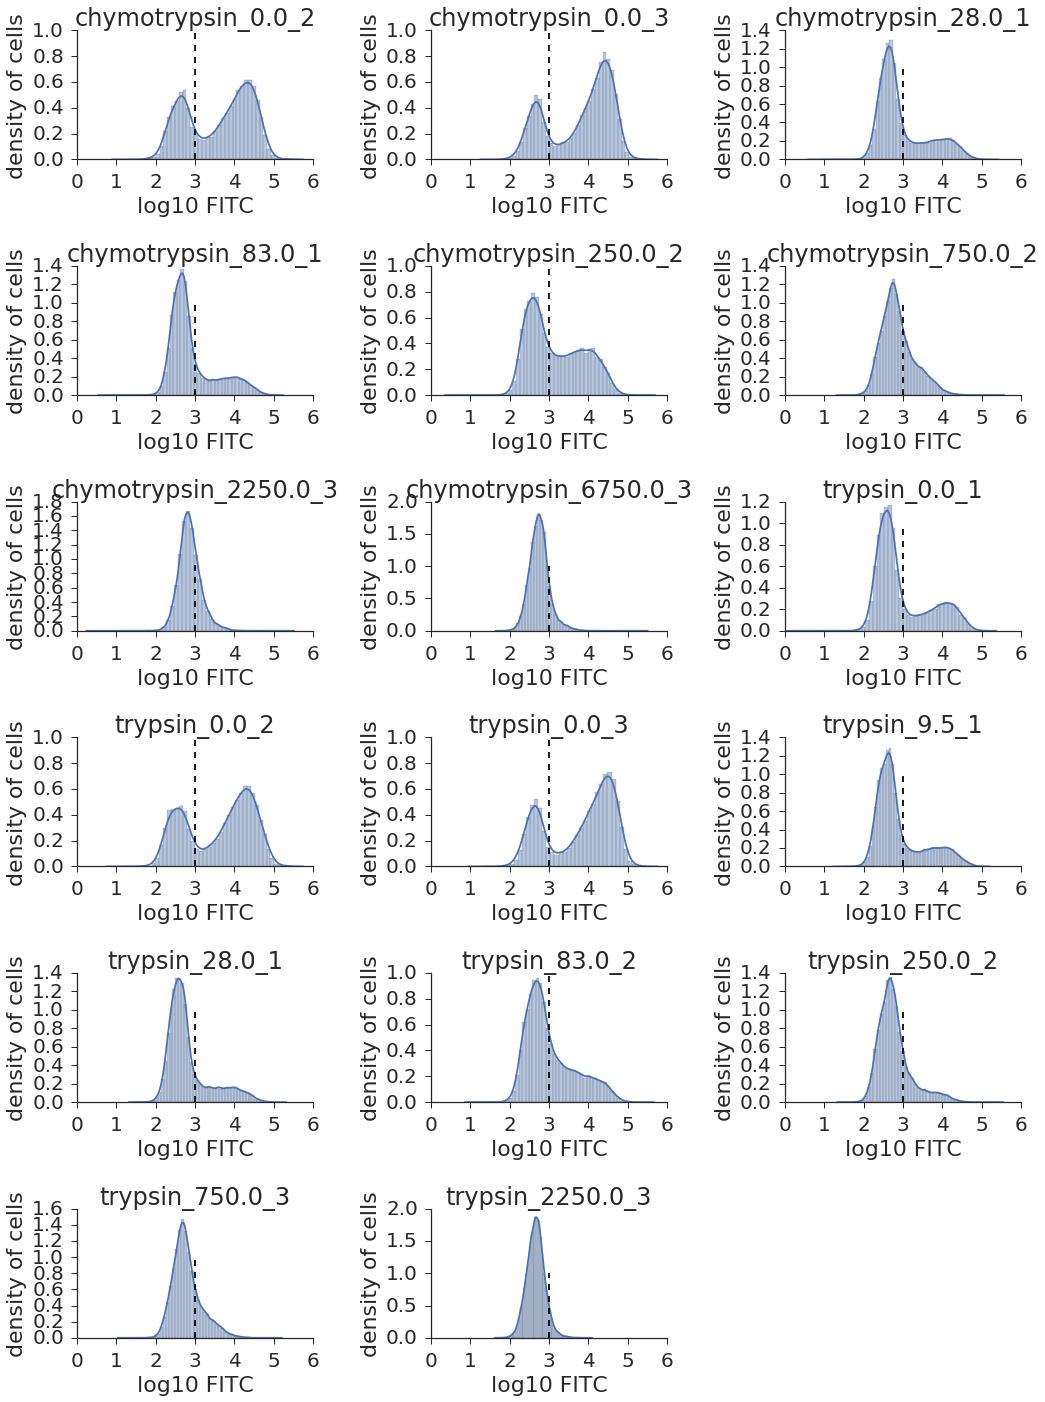

In [7]:
# Make a dataframe with only samples that have FACS data
# and then initiate a figure with subplots
data = summary_df[~summary_df['facs_file_name'].isnull()].copy()
nplots = len(data)
ncols = 3
nrows = int(math.ceil(nplots/float(ncols)))
xticks = list(range(0,7))
fig = plt.figure(figsize=[15,20])

# Plot the FACS data, showing the sorting threshold in each
# case
sorting_threshold = 3.0
for (plot_n, (i, row)) in enumerate(data.iterrows(), 1):

    # Get metadata and read in FACS data
    (protease_type, concentration) = i
    fcs_file = row['facs_file_name']
    selection_round = map_job_id_to_sort_round[row['job_id']]
    sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
    sample = s_log(sample, [facs_channel_name])
    df = sample.data
    
    # Plot the FACS data
    ax = fig.add_subplot(nrows, ncols, plot_n)
    sns.distplot(df[facs_channel_name], ax=ax)
    sns.despine()
    ax.set_title('{0}_{1}_{2}'.format(protease_type, concentration, selection_round))
    ax.set_xlabel('log10 FITC')
    ax.set_ylabel('density of cells')
    ax.plot([sorting_threshold, sorting_threshold], [0, 1.0], c='k', ls='--')
axs = fig.get_axes()
plt.setp(axs, xticks=xticks)
plt.tight_layout()
plt.show()

Compute `parent_expression` values. For each sample, this value gives the fraction of cells passing the FITC cutoff in a protease-naive untreated control sample, setting a baseline for how many cells would be expected to pass in the absence of protease. After computing these values, I will remove the naive samples used to compute these values as they are not used in further analysis.

In [8]:
# Make a dictionary that gives `parent_expression` values for each sorting round
print("The following rounds have identical naive controls: {0}".format(
    ', '.join(map(str, sort_rounds_with_identical_control))
))
naive_sample_expression = {'trypsin':{}, 'chymotrypsin':{}}
list_of_indices_to_drop = []

for (i, row) in summary_df.iterrows():
    (protease, concentration) = i
    if math.isnan(concentration):
        continue
    sort_round = map_job_id_to_sort_round[row['job_id']]
    if concentration == 0.0:
        assert (sort_round not in naive_sample_expression[protease].keys()), "Found multiple controls for same round"
        
        # If a single control is used for both proteases, record an identical value
        # for both proteases. Otherwise, record protease-specific values
        if sort_round in sort_rounds_with_identical_control:
            for protease_i in naive_sample_expression.keys():
                naive_sample_expression[protease_i][sort_round] = row['fraction_collected']
        else:
            naive_sample_expression[protease][sort_round] = row['fraction_collected']
        list_of_indices_to_drop.append(i)
        
# Remove protease naive samples that will not be used in downstream steps
summary_df.drop(list_of_indices_to_drop, axis='index', inplace=True)
summary_df.reset_index(inplace=True)

# Add the `parent_expression` column
def record_parent_expression(protease, job_id):
    if job_id not in map_job_id_to_sort_round:
        return None
    else:
        sort_round = map_job_id_to_sort_round[job_id]
        if sort_round in naive_sample_expression[protease].keys():
            return naive_sample_expression[protease][sort_round]
        else:
            return None
        
summary_df['parent_expression'] = summary_df.apply(
    lambda row: record_parent_expression(row['protease'], row['job_id']), axis=1
)

The following rounds have identical naive controls: 1


Next, I will determine the total number of cells collected for each sample. These data are encoded in separate files than the ones analyzed above. In these files, the data are organized by specimen and tube numbers. These numbers are also present in the above dataframe in the column called `facs_filename_stub`. I will parse these values and then use them to match the new FACS data with the appropriate samples in the dataframe.

In [9]:
def parse_specimen_and_tube(spec_and_tube_string):
    """Parse the specimen and tube numbers from an input string with an expected pattern"""
    
    # Define the expected pattern
    spec_and_tube_pattern = re.compile(r'(?P<spec>Specimen_\d+)_(?P<tube>Tube_\d+)')
    
    # Return `None` if the input variable isn't a string or does not
    # contain the expected pattern. Otherwise, return the parsed values
    if not isinstance(spec_and_tube_string, str):
        return(pandas.Series([None, None]))
    else:
        match = re.search(spec_and_tube_pattern, spec_and_tube_string)
        if match:
            return(pandas.Series([match.group('spec'), match.group('tube')]))
        else:
            return(pandas.Series([None, None]))

summary_df[['specimen', 'tube']] = summary_df.apply(
    lambda row: parse_specimen_and_tube(row['facs_filename_stub']), axis=1
)

summary_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)
summary_df.sort_index(inplace=True)

Read in data from the XML files on the total number of cells collected. I will do this for all XML files the BIOFAB has uploaded, even ones that aren't relevant to this experiment. Then, I will identify the relevant ones using the `job_id`, `specimen`, and `tube` columns.

In [10]:
# Compile data in each XML file
xml_data_dict = {
    key : []
    for key in ['job_id', 'specimen', 'tube', 'cells_collected', 'intended_number_of_cells_collected'] #
}
cells_collected_pattern = re.compile(r'\w+ : (?P<cells_collected>\d+) / (?P<intended_number_of_cells_collected>\d+)')
xml_files = glob.glob(os.path.join(facs_dir, '*/*/*.xml'))
for filename in xml_files:
    tree = ET.parse(filename)
    root = tree.getroot()

    # Get experiment metadata
    xml_data_dict['job_id'].append( root.findall(".//*[@name='Experiment']")[0].get('value') )
    xml_data_dict['specimen'].append( root.findall(".//*[@name='Specimen']")[0].get('value') )
    xml_data_dict['tube'].append( root.findall(".//*[@name='Tube']")[0].get('value') )
    xml_data_dict['xmlfile'] = filename
    
    # Get experiment counts
    cells_collected_data = root[4].findall(".//*[@col='1']")[0].text
    match = re.match(cells_collected_pattern, cells_collected_data)
    if match:
        xml_data_dict['cells_collected'].append(
            int(match.group('cells_collected'))
        )
        xml_data_dict['intended_number_of_cells_collected'].append(
            int(match.group('intended_number_of_cells_collected'))
        )
    else:
        xml_data_dict['cells_collected'].append(None)
        xml_data_dict['intended_number_of_cells_collected'].append(None)
          
# Convert data to a dataframe
xml_data_df = pandas.DataFrame.from_dict(xml_data_dict)
xml_data_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)

# Check for entries with duplicate indices and remove the one with the
# fewest counts if multiple exist
if sum(xml_data_df.index.duplicated()) > 0:
    print("Found duplicate indices. Will keep the duplicate with the highest counts, removing the rest")
    xml_data_df.sort_values(by='cells_collected', ascending=False, inplace=True)
    xml_data_df = xml_data_df[~xml_data_df.index.duplicated()]

Merge the FACS data from the two input sources

In [11]:
# Merge the two sources of FACS data
summary_df = summary_df.merge(
    xml_data_df[['cells_collected', 'intended_number_of_cells_collected']],
    left_index=True, right_index=True, how='left'
)

### Tweak the names of certain entries and manually add missing columns

Change the entry for the protease-naive unsorted sample to have the `protease` column equal `trypsin` and the `concentration` column to equal `0.0`, which is consistent with the naming scheme used in Rocklin et al., 2017, Science.

In [12]:
# Add a row for a naive sample for each protease
trypsin_naive_df = summary_df[
    summary_df['protease'] == 'naive'
].replace('naive', 'trypsin')

chymotrypsin_naive_df = summary_df[
    summary_df['protease'] == 'naive'
].replace('naive', 'chymotrypsin')
summary_df = pandas.concat([summary_df, trypsin_naive_df, chymotrypsin_naive_df])

# Convert the concentration of the naive samples to `0.0`, drop the row with `naive`
# in the `protease` column, then sort by protease and concentration
summary_df['concentration'].replace(np.nan, 0.0, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.set_index(['protease', 'concentration'], inplace=True)
summary_df.drop(('naive', 0.0), inplace=True)
summary_df.sort_index(inplace=True)

Manually add missing columns

In [13]:
summary_df['experiment_id'] = library_name
summary_df['selection_strength'] = 2 * [i for i in range(0,7)]
summary_df['conc_factor'] = 2 * ['', '3', '3', '3', '3', '3', '3']
summary_df['parent'] = 2 * ['', '0', '0', '2', '2', '4', '4']

Rename columns, write the final dataframe to an output file, and show the final dataframe.

In [14]:
# Rename columns
summary_df.reset_index(inplace=True)
summary_df['protease_type']=summary_df['protease']

column_order = [
    'experiment_id', 'protease_type', 'concentration', 'selection_strength', 'parent', 'conc_factor', 'fastq_id',
    'parent_expression', 'fraction_collected', 'cells_collected'
]

# Write the dataframe to an output file
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)
print("Writing metadata to the experimental summary file: {0}".format(experimental_metadata_output_file))
summary_df[column_order].to_csv(experimental_metadata_output_file, index=False)

# Show the final dataframe
summary_df[column_order]

Writing metadata to the experimental summary file: results/template_notebook/experimental_metadata_from_script.csv


,experiment_id,protease_type,concentration,selection_strength,parent,conc_factor,fastq_id,parent_expression,fraction_collected,cells_collected
0,protein design downselect 3 with ladder 1,chymotrypsin,0.0,0,,,146289/Files/,NaN,NaN,NaN
1,protein design downselect 3 with ladder 1,chymotrypsin,28.0,1,0,3,146285/Files/,0.318721,0.315533,3804000.0
2,protein design downselect 3 with ladder 1,chymotrypsin,83.0,2,0,3,146286/Files/,0.318721,0.280800,3383999.0
3,protein design downselect 3 with ladder 1,chymotrypsin,250.0,3,2,3,146290/Files/,0.670700,0.494100,3798490.0
4,protein design downselect 3 with ladder 1,chymotrypsin,750.0,4,2,3,146291/Files/,0.670700,0.308367,3744000.0
5,protein design downselect 3 with ladder 1,chymotrypsin,2250.0,5,4,3,146294/Files/,0.742600,0.271367,3172028.0
6,protein design downselect 3 with ladder 1,chymotrypsin,6750.0,6,4,3,146295/Files/,0.742600,0.132167,1632000.0
7,protein design downselect 3 with ladder 1,trypsin,0.0,0,,,146289/Files/,NaN,NaN,NaN
8,protein design downselect 3 with ladder 1,trypsin,9.5,1,0,3,146287/Files/,0.318721,0.285543,3443999.0
9,protein design downselect 3 with ladder 1,trypsin,28.0,2,0,3,146288/Files/,0.318721,0.234500,2623005.0


## 3) Compute EC50 values from the experimental data

In the below cell, I assemble and print a command-line argument for running the script `compute_ec50_values_from_deep_sequencing_data.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_ec50_values.yml` and then executing the arguement, which I will do manually.

In [15]:
# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_metadata_output_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--five_prime_flanking_seq {0}'.format(five_prime_flanking_seq),
    '--three_prime_flanking_seq {0}'.format(three_prime_flanking_seq),
    '--output_dir {0}'.format(resultsdir)
])
print("To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml:\n")
print('source activate 2018_prot_stab_compute_ec50_values')
print("\nThen run the command:\n")
print(cmd)

To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml:

source activate 2018_prot_stab_compute_ec50_values

Then run the command:

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file data/template_notebook/designed_sequences.csv --experimental_summary_file results/template_notebook/experimental_metadata_from_script.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/protein_design_data/Plan_18338/ngs_data/ --pear_path /home/05402/haddox/software/pear/bin/pear --five_prime_flanking_seq CATATG --three_prime_flanking_seq CTCGAG --output_dir results/template_notebook


## 4) Compute stability scores from EC50 values

In the below cell, I assemble and print a command-line argument for running the script `compute_stability_scores_from_EC50_values.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_stability_scores.yml` and then executing the below arguements, which I will do manually.

In [16]:
# Put together the command
print("To complete this step, manually activate the environment encoded in environment_compute_stability_scores.yml\n")
print('source activate 2018_prot_stab_compute_stability_scores')
print("\nThen run the commands:\n")
for protease in proteases:

    # Define the names of the input file with EC50 values and the output file
    # that will have the computed stability scores
    ec50_values_file = os.path.join(
        resultsdir,
        'ec50_values/{0}.fulloutput'.format(protease)
    )
    output_file = os.path.join(
        resultsdir,
        'stability_scores/{0}_stability_scores.txt'.format(protease)
    )

    # Define and print the command
    cmd = ' '.join([
        'python',
        'scripts/compute_stability_scores_from_EC50_values.py',
        designed_sequences_file,
        protease,
        ec50_values_file,
        conc_factor,
        output_file
    ])

    print(cmd)
    print('\n')

To complete this step, manually activate the environment encoded in environment_compute_stability_scores.yml

source activate 2018_prot_stab_compute_stability_scores

Then run the commands:

python scripts/compute_stability_scores_from_EC50_values.py data/template_notebook/designed_sequences.csv trypsin results/template_notebook/ec50_values/trypsin.fulloutput 3 results/template_notebook/stability_scores/trypsin_stability_scores.txt


python scripts/compute_stability_scores_from_EC50_values.py data/template_notebook/designed_sequences.csv chymotrypsin results/template_notebook/ec50_values/chymotrypsin.fulloutput 3 results/template_notebook/stability_scores/chymotrypsin_stability_scores.txt




Next, merge stability scores between proteases, computing the minimum stability scores for the two proteases, and creating a file with a single dataframe with data from each protease, with suffixes of `_t` or `_c` indicating that the data is derived from trypsin or chymotrypsin, respectively, and a new column called `stabilityscore` that gives the minimum stability score between the two proteases.

In [18]:
stability_scores_trypsin_file = os.path.join(
    resultsdir,
    'stability_scores/trypsin_stability_scores.txt'
)
stability_scores_chymotrypsin_file = os.path.join(
    resultsdir,
    'stability_scores/chymotrypsin_stability_scores.txt'
)
merged_stability_scores_outfile = os.path.join(
    resultsdir,
    'stability_scores/stability_scores.txt'
)
print("Writing merged stability scores to the file: {0}".format(merged_stability_scores_outfile))
prot_stab_utils.merge_stability_scores_between_proteases(
    stability_scores_trypsin_file,
    stability_scores_chymotrypsin_file,
    merged_stability_scores_outfile
)

Writing merged stability scores to the file: results/template_notebook/stability_scores/stability_scores.txt


## 5) Make summary plots

In the below cell, I define input variables and then assemble and print a command-line argument for running the script `create_summary_plots.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_ec50_values.yml` and then executing the arguement, which I will do manually.

In [19]:
# Define input variables
data_dir = resultsdir
output_dir = os.path.join(resultsdir, 'summary_plots/')

# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/create_summary_plots.py',
    '--data_dir {0}'.format(data_dir),
    '--output_dir {0}'.format(output_dir)
])

print("To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml:\n")
print('source activate 2018_prot_stab_compute_ec50_values')
print("\nThen run the command:\n")
print(cmd)

To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml:

source activate 2018_prot_stab_compute_ec50_values

Then run the command:

python scripts/create_summary_plots.py --data_dir results/template_notebook --output_dir results/template_notebook/summary_plots/


Show the number of assembled paired-end reads per sample, as well as the number of reads that could not be assembled or were discarded.

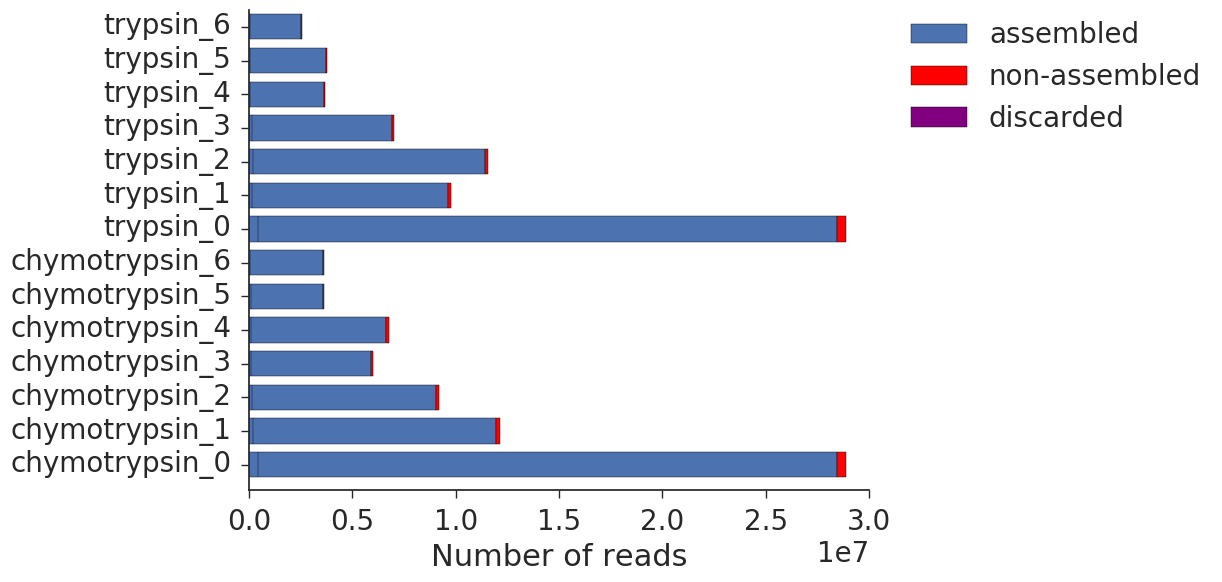

In [20]:
Image(os.path.join(output_dir, "deep_sequencing_depth_and_quality.png"), width=700)